# HuggingFace Tutorial

In [2]:
import joblib
import sys
import os
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from huggingface_hub import HfFolder,notebook_login,HfApi,snapshot_download
import matplotlib.pyplot as plt
from torchsummary import summary
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader



C:\Users\Michael\AppData\Local\Temp\ipykernel_35636\705529812.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Login into Huggingface and paste your API token below

If you have 401 authentication error, please invalidate and refresh your token. This can be done by going to your user api account settings and click manage token. If you still have problems reload the notebook_login without saving to environment variables and try again. (cell 3)

In [3]:
notebook_login()

In [3]:
# Get the current working directory
current_dir = os.getcwd()

# Assuming the current directory is 'models', get the path of the 'TAQ-Query-Scripts' directory
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to sys.path
sys.path.append(parent_dir)

token = os.getenv("hf_token")
user_token= os.getenv("hf_user_token")

# Use the token to authenticate
HfFolder.save_token(token)

### Load the data

In [ ]:
# Load the dataset
df_test = pd.read_csv('../sample_data/sample_features.csv')
df_test['Trade_Price'] = df_test['Trade_Price'].fillna(df_test['Trade_Price'].median())



### Model Setup

- Model Target (Y) = Trade Price
- Model Features (X) = Lagged Trade Volume, Lagged Bid Price, and Lagged Offer Price. 

In [ ]:
# Selecting features for the model
features = ['Trade_Volume', 'Bid_Price', 'Offer_Price']  # Example features
target = 'Trade_Price'


# Drop rows with missing target or features
df_test = df_test.dropna(subset=[target] + features)

# Define X (features) and y (target)
X = df_test[features]
y = df_test[target]

### Training Model with StatsModels

In [1]:

# Adding a constant to the model (important for OLS regression)
X = sm.add_constant(X)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the OLS model
model = sm.OLS(y_train, X_train).fit()

# Print model summary
print(model.summary())

# Save the model to a file
model_filename = 'ols_model/ols_model.pkl'
joblib.dump(model, model_filename)

print(f"Model saved as {model_filename}")



Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/jbohne/anaconda3/envs/taq/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
  File "/tmp/ipykernel_15539/3071508085.py", line 2, in <module>
    df_test = pd.read_csv('../sample_data/sample_features.csv')
              ^^
NameError: name 'pd' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jbohne/anaconda3/envs/taq/lib/python3.11/site-packages/pygments/styles/__init__.py", line 45, in get_style_by_name
ModuleNotFoundError: No module named 'pygments.styles.default'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jbohne/anaconda3/envs/taq/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
  File "/home/jbohne/anaconda3/envs/taq/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1435, in structured_tr

In [ ]:
# Visualization plot
plt.scatter(X_train['Trade_Volume'], y_train, label='Training Data')
plt.scatter(X_test['Trade_Volume'], y_test, color='red', label='Testing Data')
plt.xlabel('Trade Volume')
plt.ylabel('Trade Price')
plt.title('Trade Volume vs Trade Price')
plt.legend()
plt.savefig("ols_model/plot.png")
plt.show()

#### Training Modle with PyTorch

Epoch [10/100], Loss: inf
Epoch [20/100], Loss: nan
Epoch [30/100], Loss: nan
Epoch [40/100], Loss: nan
Epoch [50/100], Loss: nan
Epoch [60/100], Loss: nan
Epoch [70/100], Loss: nan
Epoch [80/100], Loss: nan
Epoch [90/100], Loss: nan
Epoch [100/100], Loss: nan


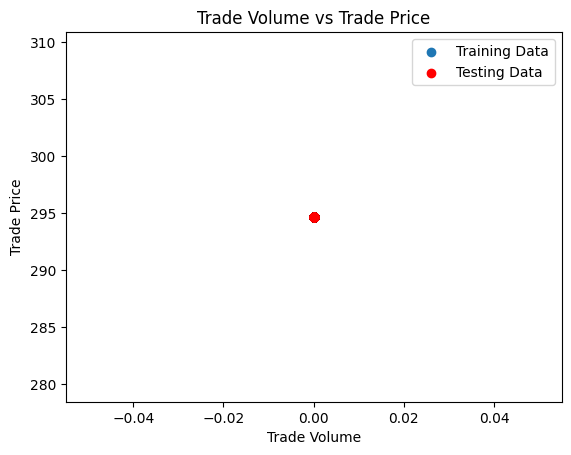

In [5]:

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert DataFrame to Tensors
X_train_tensor = torch.tensor(X_train.values.astype(np.float32))
y_train_tensor = torch.tensor(y_train.values.astype(np.float32).reshape(-1, 1))
X_test_tensor = torch.tensor(X_test.values.astype(np.float32))
y_test_tensor = torch.tensor(y_test.values.astype(np.float32).reshape(-1, 1))


In [ ]:
# PyTorch Model Definition
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

# Initialize the model
input_size = X_train_tensor.shape[1]
model = LinearRegressionModel(input_size)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:

# Visualization plot
plt.scatter(X_train['Trade_Volume'], y_train, label='Training Data')
plt.scatter(X_test['Trade_Volume'], y_test, color='red', label='Testing Data')
plt.xlabel('Trade Volume')
plt.ylabel('Trade Price')
plt.title('Trade Volume vs Trade Price')
plt.legend()
plt.show()

# Save the model
torch.save(model.state_dict(), 'ols_model/pytorch_linear_regression_model.pth')

### Push Model to HuggingFace

For write access you will need to use a user-access token. You can create one by going to your profile settings and clicking on "New token". Make sure to copy the token after creating it, as you won't be able to access it afterwards.

In [6]:
# push the model to the hub
api = HfApi()
api.upload_file(
    path_or_fileobj="ols_model/ols_model.pkl",
    path_in_repo="ols_model/ols_model.pkl",
    repo_id="taqdatabase/OLS",
    repo_type="model",
)


ols_model.pkl:   0%|          | 0.00/197k [00:00<?, ?B/s]

'https://huggingface.co/taqdatabase/OLS/blob/main/ols_model/ols_model.pkl'

In [9]:
# Model file path
model_file_path = "ols_model\pytorch_linear_regression_model.pth"

# Push the model to the hub
api = HfApi()
api.upload_file(
    path_or_fileobj=model_file_path,
    path_in_repo="ols_model/pytorch_linear_regression_model.pth",
    repo_id="taqdatabase/OLS",
    repo_type="model",
)

'https://huggingface.co/taqdatabase/OLS/blob/main/ols_model/pytorch_linear_regression_model.pth'

In [10]:
# push the plot to the hub
api = HfApi()
api.upload_file(
    path_or_fileobj="ols_model/plot.png",
    path_in_repo="ols_model/plots/plot.png",   # Change this to the desired path in the repo
    repo_id="taqdatabase/OLS",      # Change "username/repo_name" to your Hugging Face Hub repo
    repo_type="model"                # Use "model" or "dataset" depending on the repository type
)

'https://huggingface.co/taqdatabase/OLS/blob/main/ols_model/plots/plot.png'

### Examine Model Summary CSV

In [17]:
# Generate model summary with torchsummary
summary(model, input_size=(1, input_size))

# Function to get model summary for CSV export
def get_model_summary(model, input_size):
    summary = []
    for layer in model.children():
        layer_str = str(layer)
        layer_type = layer_str[:layer_str.find('(')].strip()
        param = sum([p.numel() for p in layer.parameters()])
        summary.append([layer_type, param])
    return summary

# Export model summary to CSV
model_summary = get_model_summary(model, input_size)
with open('ols_model/model_summary.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Layer Type", "Parameters"])  # Writing header
    for row in model_summary:
        writer.writerow(row)

print("Model summary exported to model_summary.csv")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 1]               4
Total params: 4
Trainable params: 4
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
Model summary exported to model_summary.csv


### Push CSV to HuggingFace

In [18]:
# push the model to the hub
api = HfApi()
api.upload_file(
    path_or_fileobj="ols_model/ols_model_summary.csv",
    path_in_repo="ols_model/ols_model_summary.csv",
    repo_id="taqdatabase/OLS",
    repo_type="model",
)

'https://huggingface.co/taqdatabase/OLS/blob/main/ols_model/ols_model_summary.csv'


### Load Model from HuggingFace Hub

In [28]:
snapshot_download(repo_id="taqdatabase/OLS")

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]
.gitattributes: 100%|██████████| 1.52k/1.52k [00:00<00:00, 891kB/s]
README.md: 100%|██████████| 97.0/97.0 [00:00<00:00, 3.10kB/s]
ols_model.pkl: 100%|██████████| 197k/197k [00:00<00:00, 2.82MB/s]
Fetching 3 files: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]


'/home/jbohne/.cache/huggingface/hub/models--taqdatabase--OLS/snapshots/3ccc806307a32f9787b088a3c8001407798ebf06'

### Training Model with PyTorch Lightning

In [ ]:
data=pd.read_csv('..\sample_data\sample_features.csv')
# Preprocessing
data.fillna(0, inplace=True)  # Handling missing values
data['Is_Quote'] = data['Is_Quote'].astype(int)
data['Valid_Quotes'] = data['Valid_Quotes'].astype(int)
data['Participant_Timestamp'] = pd.to_datetime(data['Participant_Timestamp'])
data['hour'] = data['Participant_Timestamp'].dt.hour
data['minute'] = data['Participant_Timestamp'].dt.minute
data['second'] = data['Participant_Timestamp'].dt.second
data.drop(['Symbol', 'Trade_Reporting_Facility', 'Participant_Timestamp'], axis=1, inplace=True)

# Separate features and target
X = data.drop('Trade_Price', axis=1)
y = data['Trade_Price']

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


In [51]:

# Dataset and DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
test_dataset = TimeSeriesDataset(X_test_tensor, y_test_tensor)

# LightningModule
class MyTimeSeriesModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(X_train.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def train_dataloader(self):
        return DataLoader(train_dataset, batch_size=15, shuffle=True)

    def val_dataloader(self):
        return DataLoader(test_dataset, batch_size=15)

# Instantiate and train the model
model = MyTimeSeriesModel()
trainer = pl.Trainer(max_epochs=25)
trainer.fit(model)

# Save the model
trainer.save_checkpoint("ols_model/ols_model.ckpt")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Python311\Lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 1.0 K 
-------------------------------------
1.0 K     Trainable params
0         Non-trainable params
1.0 K     Total params
0.004     Total estimated model params size (MB)


c:\Python311\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

C:\Users\Michael\AppData\Local\Temp\ipykernel_37044\1301968496.py:56: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(y_hat, y)
C:\Users\Michael\AppData\Local\Temp\ipykernel_37044\1301968496.py:56: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(y_hat, y)
`Trainer.fit` stopped: `max_epochs=25` reached.


### Evaluate Model

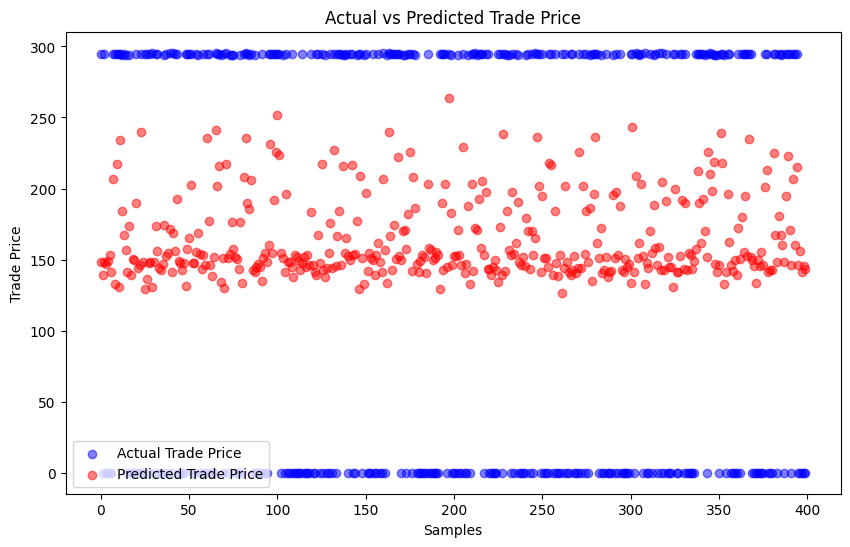

In [50]:

# Generate predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_test_tensor).view(-1)  # Flatten the predictions

# Convert predictions to a numpy array
predictions = predictions.numpy()

# Plot actual vs predicted values using dots
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test.values, label='Actual Trade Price', color='blue', alpha=0.5)
plt.scatter(range(len(predictions)), predictions, label='Predicted Trade Price', color='red', alpha=0.5)
plt.title('Actual vs Predicted Trade Price')
plt.xlabel('Samples')
plt.ylabel('Trade Price')
plt.legend()
plt.show()

### Push Model to HuggingFace

In [ ]:
from huggingface_hub import HfApi

api = HfApi()

# Make sure the path to the saved model is correct
api.upload_file(
    path_or_fileobj="ols_model/ols_model.ckpt",
    path_in_repo="ols_model/ols_model.ckpt",
    repo_id="taqdatabase/OLS",
    repo_type="model",
)
